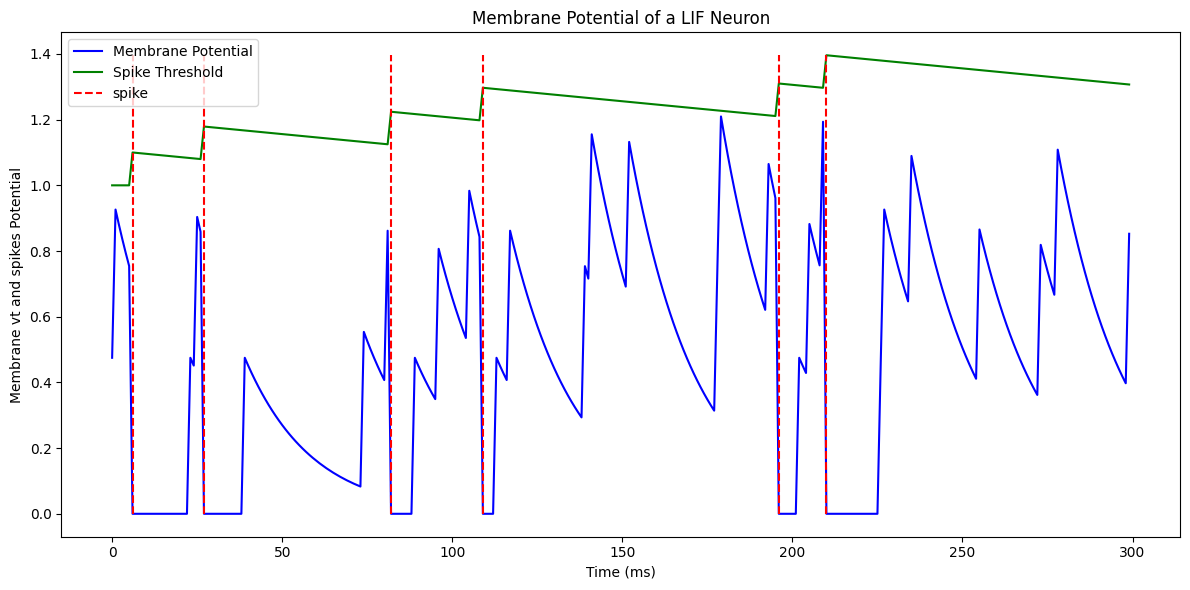

In [60]:
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output, display

class neuron:
    def __init__(self, w, vt):
        self.w = w
        self.v = 0.5

        self.vt = vt
        self.vt_min = 1.0

        self.dt = 1.0

        # rate of decay
        self.voltage_threshold_decay_rate = 0.001
        self.voltage_decay_rate = 20.0

    def forward(self, num_input_spikes):
        # update the membrane potential
        self.v += (self.w * num_input_spikes)

        # decay the membrane potential
        self.v -= (self.v / self.voltage_decay_rate) * self.dt

        # threshold decay
        self.vt -= self.voltage_threshold_decay_rate
        # clip the membrane potential
        self.vt = max(self.vt_min, self.vt)

        # check if the neuron has exceeded the spike threshold
        if self.v >= self.vt:
            # increase decaying threshold linearly
            self.vt += 0.1

            # reset the membrane potential
            self.v = 0.0
            return 1
        else:
            self.v = max(0.0, self.v)
            return 0


history_of_voltage_threshold = []
history_of_voltage = []
history_of_spikes = []
neuron = neuron(w = 0.5, vt = 1.0)
for timestep in range(300):
    if np.random.random_sample() > 0.9: spike = neuron.forward(1.0)
    else:                               spike = neuron.forward(0.0)

    history_of_voltage.append(neuron.v)
    history_of_spikes.append(spike)
    history_of_voltage_threshold.append(neuron.vt)

# plot the simulation results
plt.figure(figsize=(12, 6))
plt.plot(history_of_voltage, c='b', label='Membrane Potential')
plt.plot(history_of_voltage_threshold, c='g', label='Spike Threshold')

spike_time = [i for i, x in enumerate(history_of_spikes) if x == 1]
spike_voltage = [history_of_voltage[i] for i in spike_time]
plt.vlines(x=spike_time, ymin=0, ymax=max(history_of_voltage_threshold), color='r', linestyles='dashed')

plt.legend(['Membrane Potential', 'Spike Threshold', "spike"])
plt.ylabel('Membrane vt and spikes Potential')
plt.xlabel('Time (ms)')
plt.title('Membrane Potential of a LIF Neuron')

plt.tight_layout()
plt.show()

# clear_output(wait=True) # Clear the previous output
# display(plt.gcf())      # Display the current figure
# plt.close()             # Close the figure to prevent display overlap
# time.sleep(2.0)         # Pause for a short period of time to create an animation effect


[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 3 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 3 2]


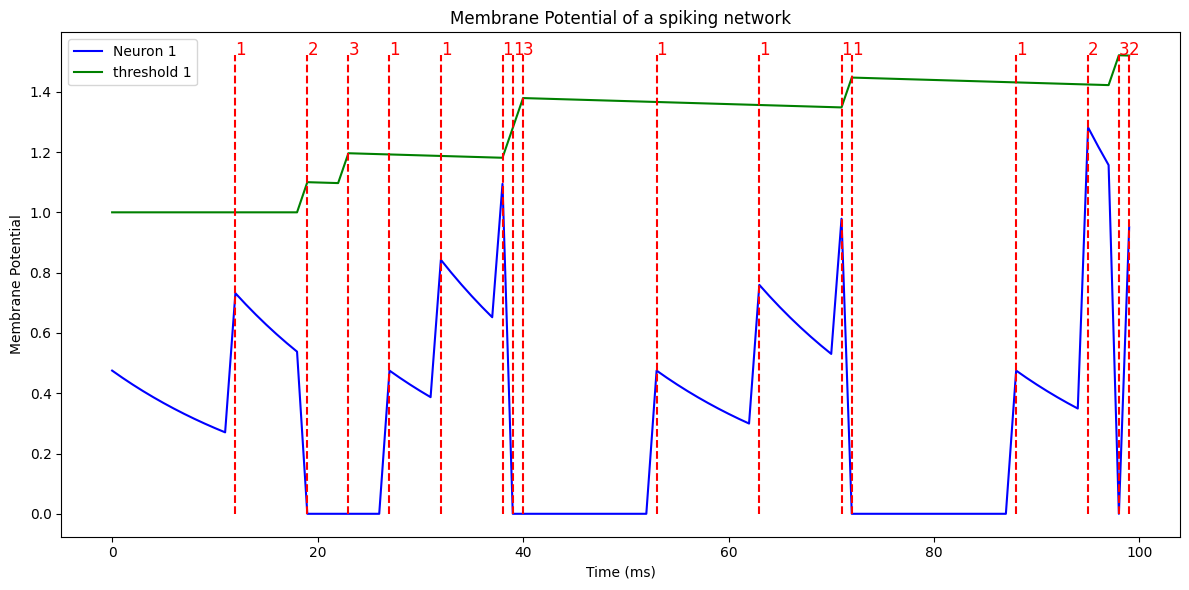

In [116]:
import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output, display

class spiking_network:
    def __init__(self, size):
        self.num_neurons = size

        self.w = torch.ones(self.num_neurons) * 0.5
        self.v = torch.ones(self.num_neurons) * 0.5

        self.vt     = torch.ones(self.num_neurons)
        self.vt_min = torch.ones(self.num_neurons)

        self.spikes = torch.zeros(self.num_neurons, dtype=torch.int)

        self.dt = 1.0  # time step

        # rate of decay
        self.voltage_threshold_decay_rate = 0.001
        self.voltage_decay_rate = 20.0

    def forward(self):
        # update the membrane potential
        self.v += (self.w * self.spikes)
        self.v -= (self.v / self.voltage_decay_rate) * self.dt  # decay the membrane potential

        # threshold decay
        self.vt -= self.voltage_threshold_decay_rate
        self.vt[self.vt < 1.0] = 1.0  # clip the membrane potential

        # update the spikes
        spiking_neurons = self.v >= self.vt   # check which neurons have exceeded the spike threshold
        self.vt[spiking_neurons] += 0.1       # increase decaying threshold linearly
        self.v[spiking_neurons] = 0.0         # reset the membrane potential

        # reset the membrane potential
        self.v = torch.clamp(self.v, min=0.0)

        return spiking_neurons

num_neurons = 10
spike_network = spiking_network(size=num_neurons)

history_of_voltage_threshold, history_of_voltage, history_of_spikes, history_of_random_spikes = [], [], [], []
probabilities = torch.tensor([0.8, 0.1, 0.05, 0.04, 0.005, 0.005])
probabilities = probabilities / probabilities.sum()
for timestep in range(100):
    # generate random spikes
    spike_network.spikes = torch.multinomial(probabilities, num_neurons, replacement=True)

    # forward pass
    spiking_neurons = spike_network.forward()

    # store the results
    history_of_random_spikes.append(spike_network.spikes.clone())
    history_of_spikes.append(spiking_neurons.clone())
    history_of_voltage.append(spike_network.v.clone())
    history_of_voltage_threshold.append(spike_network.vt.clone())

history_of_spikes = np.array(history_of_spikes)
history_of_voltage = np.array(history_of_voltage)
history_of_random_spikes = np.array(history_of_random_spikes)
history_of_voltage_threshold = np.array(history_of_voltage_threshold)

plt.figure(figsize=(12, 6))
neuron_to_plot = 1
plt.plot(history_of_voltage[:, neuron_to_plot], label=f'Neuron {1}', c='b')
plt.plot(history_of_voltage_threshold[:, neuron_to_plot], label=f'threshold {1}', c='g')

# plot the input spikes (random spikes)
print(history_of_random_spikes[:,neuron_to_plot])
spike_time = [i for i, x in enumerate(history_of_random_spikes[:, neuron_to_plot]) if x >= 1]
spike_numbers = history_of_random_spikes[:, neuron_to_plot][spike_time]

plt.vlines(x=spike_time, ymin=0, ymax=max(history_of_voltage_threshold[:, neuron_to_plot]), color='r', linestyles='dashed')
for i in range(len(spike_numbers)):  # add the number of spikes as a letter above the spike
    plt.text(spike_time[i], max(history_of_voltage_threshold[:, neuron_to_plot]), str(spike_numbers[i]), fontsize=12, color='r')

plt.ylabel('Membrane Potential')
plt.xlabel('Time (ms)')
plt.title('Membrane Potential of a spiking network')
plt.legend()
plt.tight_layout()
plt.show()